## 加载 MNIST 数据集并合并训练集与测试集

In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="data/", train=True, download=False, transform=transform
)

test_dataset = datasets.MNIST(
    root="data/", train=False, download=False, transform=transform
)

dataset = ConcatDataset([train_dataset, test_dataset])

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"总数据集大小: {len(dataset)}")

训练集大小: 60000
测试集大小: 10000
总数据集大小: 70000


## 可视化MNIST样本
每张图是 28 × 28 的灰度 MNIST 手写数字

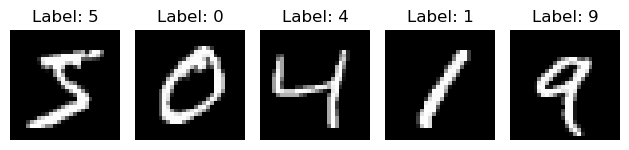

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5)

for i in range(5):
    image, label = dataset[i]
    axes[i].imshow(image.squeeze(0), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 用于 MNIST 的条件 GAN（cGAN） 网络

条件信息采用 one-hot 标签形式，并通过全连接层与图像特征进行融合
使用 PyTorch 定义一个基于全连接层的 cGAN：
- 生成器（Generator）：将随机噪声和类别标签的 one-hot 编码映射为 MNIST 图像
- 判别器（Discriminator）：判断输入图像在给定条件下为“真实”的概率

In [18]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_dim=28 * 28):
        super().__init__()
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        labels_onehot = torch.nn.functional.one_hot(labels, self.num_classes).float()
        x = torch.cat([z, labels_onehot], dim=1)
        img = self.model(x)

        return img


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_dim=28 * 28):
        super().__init__()
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(img_dim + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        labels_onehot = torch.nn.functional.one_hot(labels, self.num_classes).float()

        x = torch.cat([img, labels_onehot], dim=1)
        validity = self.model(x)

        return validity

## 构建 DataLoader 并初始化 GAN

In [19]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## 训练

Epoch [001/100] | G Loss: 6.1498 | D Loss: 0.0205
Epoch [002/100] | G Loss: 10.9268 | D Loss: 0.0861
Epoch [003/100] | G Loss: 9.9980 | D Loss: 0.5817
Epoch [004/100] | G Loss: 2.5402 | D Loss: 0.4412
Epoch [005/100] | G Loss: 1.4263 | D Loss: 0.7511
Epoch [006/100] | G Loss: 2.2630 | D Loss: 0.3356
Epoch [007/100] | G Loss: 2.0103 | D Loss: 0.5416
Epoch [008/100] | G Loss: 3.1827 | D Loss: 0.2390
Epoch [009/100] | G Loss: 2.4409 | D Loss: 0.6476
Epoch [010/100] | G Loss: 2.5031 | D Loss: 0.3187


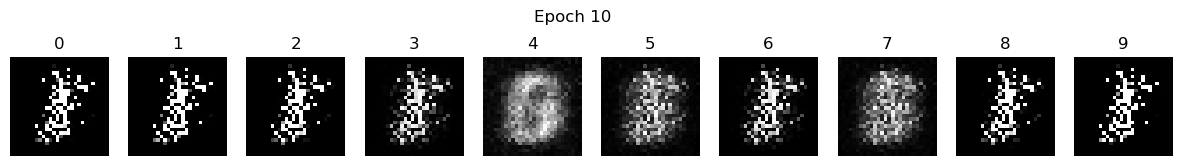

Epoch [011/100] | G Loss: 3.9143 | D Loss: 0.1947
Epoch [012/100] | G Loss: 2.7570 | D Loss: 0.5081
Epoch [013/100] | G Loss: 3.8257 | D Loss: 0.2734
Epoch [014/100] | G Loss: 4.3009 | D Loss: 0.1217
Epoch [015/100] | G Loss: 5.5192 | D Loss: 0.1292
Epoch [016/100] | G Loss: 4.9617 | D Loss: 0.0748
Epoch [017/100] | G Loss: 5.7962 | D Loss: 0.1410
Epoch [018/100] | G Loss: 3.1682 | D Loss: 0.2030
Epoch [019/100] | G Loss: 3.2216 | D Loss: 0.1751
Epoch [020/100] | G Loss: 4.6723 | D Loss: 0.2625


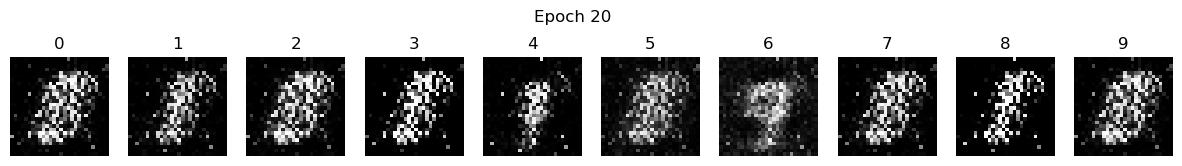

Epoch [021/100] | G Loss: 4.4895 | D Loss: 0.2233
Epoch [022/100] | G Loss: 4.1880 | D Loss: 0.1962
Epoch [023/100] | G Loss: 5.8347 | D Loss: 0.0712
Epoch [024/100] | G Loss: 4.2014 | D Loss: 0.1406
Epoch [025/100] | G Loss: 4.6688 | D Loss: 0.1440
Epoch [026/100] | G Loss: 4.4749 | D Loss: 0.2438
Epoch [027/100] | G Loss: 5.5166 | D Loss: 0.1749
Epoch [028/100] | G Loss: 3.7882 | D Loss: 0.1950
Epoch [029/100] | G Loss: 4.7525 | D Loss: 0.2238
Epoch [030/100] | G Loss: 7.9772 | D Loss: 0.1779


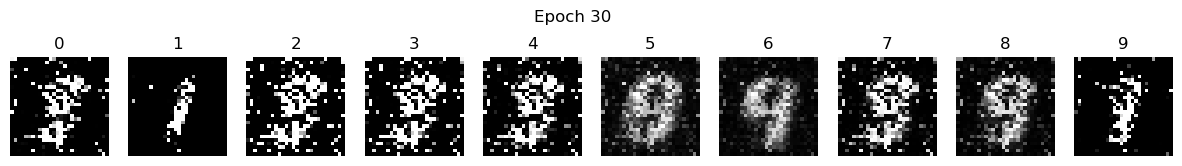

Epoch [031/100] | G Loss: 4.0153 | D Loss: 0.2128
Epoch [032/100] | G Loss: 6.0053 | D Loss: 0.0839
Epoch [033/100] | G Loss: 5.2764 | D Loss: 0.1409
Epoch [034/100] | G Loss: 4.6910 | D Loss: 0.1322
Epoch [035/100] | G Loss: 4.3522 | D Loss: 0.1937
Epoch [036/100] | G Loss: 3.8731 | D Loss: 0.1381
Epoch [037/100] | G Loss: 4.7099 | D Loss: 0.1527
Epoch [038/100] | G Loss: 4.2113 | D Loss: 0.1286
Epoch [039/100] | G Loss: 3.0703 | D Loss: 0.2202
Epoch [040/100] | G Loss: 4.1929 | D Loss: 0.1783


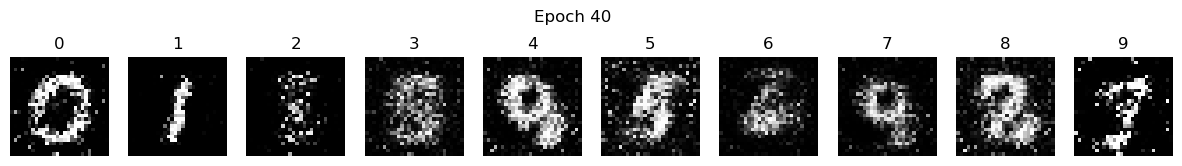

Epoch [041/100] | G Loss: 3.8018 | D Loss: 0.2522
Epoch [042/100] | G Loss: 3.5384 | D Loss: 0.2274
Epoch [043/100] | G Loss: 2.8553 | D Loss: 0.3240
Epoch [044/100] | G Loss: 3.3741 | D Loss: 0.2759
Epoch [045/100] | G Loss: 3.3608 | D Loss: 0.2795
Epoch [046/100] | G Loss: 2.3115 | D Loss: 0.2487
Epoch [047/100] | G Loss: 2.8610 | D Loss: 0.2307
Epoch [048/100] | G Loss: 2.8673 | D Loss: 0.3173
Epoch [049/100] | G Loss: 3.4256 | D Loss: 0.1948
Epoch [050/100] | G Loss: 4.1246 | D Loss: 0.2456


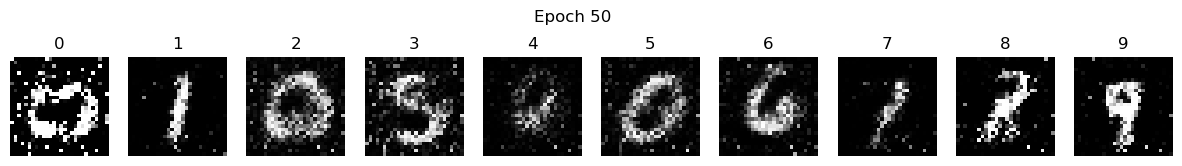

Epoch [051/100] | G Loss: 3.7898 | D Loss: 0.2458
Epoch [052/100] | G Loss: 2.7857 | D Loss: 0.2695
Epoch [053/100] | G Loss: 2.6364 | D Loss: 0.2836
Epoch [054/100] | G Loss: 2.3270 | D Loss: 0.2545
Epoch [055/100] | G Loss: 2.3875 | D Loss: 0.2908
Epoch [056/100] | G Loss: 3.0109 | D Loss: 0.2513
Epoch [057/100] | G Loss: 2.5349 | D Loss: 0.2947
Epoch [058/100] | G Loss: 1.9854 | D Loss: 0.3585
Epoch [059/100] | G Loss: 1.7344 | D Loss: 0.3756
Epoch [060/100] | G Loss: 3.3136 | D Loss: 0.3467


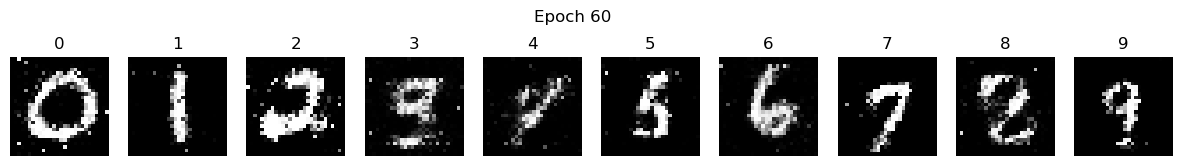

Epoch [061/100] | G Loss: 2.1639 | D Loss: 0.3687
Epoch [062/100] | G Loss: 2.1832 | D Loss: 0.4313
Epoch [063/100] | G Loss: 1.9568 | D Loss: 0.3690
Epoch [064/100] | G Loss: 2.2625 | D Loss: 0.4223
Epoch [065/100] | G Loss: 2.1335 | D Loss: 0.3883
Epoch [066/100] | G Loss: 3.0006 | D Loss: 0.2987
Epoch [067/100] | G Loss: 2.4727 | D Loss: 0.3203
Epoch [068/100] | G Loss: 2.1309 | D Loss: 0.5105
Epoch [069/100] | G Loss: 1.8871 | D Loss: 0.4736
Epoch [070/100] | G Loss: 2.0934 | D Loss: 0.2919


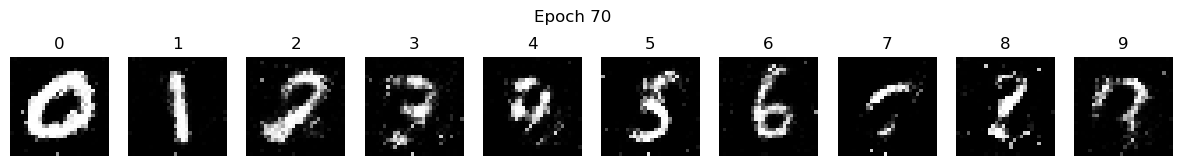

Epoch [071/100] | G Loss: 2.0172 | D Loss: 0.3008
Epoch [072/100] | G Loss: 2.4625 | D Loss: 0.3507
Epoch [073/100] | G Loss: 2.1411 | D Loss: 0.4211
Epoch [074/100] | G Loss: 2.6167 | D Loss: 0.3024
Epoch [075/100] | G Loss: 2.3796 | D Loss: 0.3570
Epoch [076/100] | G Loss: 2.2792 | D Loss: 0.4328
Epoch [077/100] | G Loss: 2.5670 | D Loss: 0.3040
Epoch [078/100] | G Loss: 1.9980 | D Loss: 0.4307
Epoch [079/100] | G Loss: 1.5998 | D Loss: 0.3965
Epoch [080/100] | G Loss: 1.5956 | D Loss: 0.5904


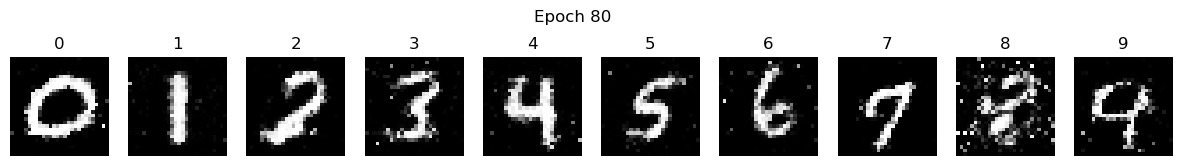

Epoch [081/100] | G Loss: 1.7885 | D Loss: 0.4880
Epoch [082/100] | G Loss: 1.6789 | D Loss: 0.3991
Epoch [083/100] | G Loss: 1.3241 | D Loss: 0.5244
Epoch [084/100] | G Loss: 1.5840 | D Loss: 0.5410
Epoch [085/100] | G Loss: 1.8310 | D Loss: 0.4357
Epoch [086/100] | G Loss: 1.4412 | D Loss: 0.5373
Epoch [087/100] | G Loss: 1.4888 | D Loss: 0.4625
Epoch [088/100] | G Loss: 1.3942 | D Loss: 0.5328
Epoch [089/100] | G Loss: 1.7658 | D Loss: 0.5007
Epoch [090/100] | G Loss: 1.5316 | D Loss: 0.5295


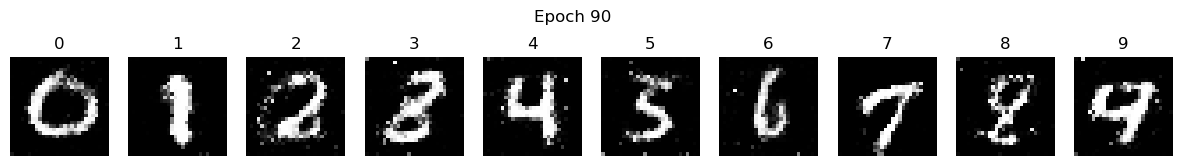

Epoch [091/100] | G Loss: 1.3263 | D Loss: 0.5839
Epoch [092/100] | G Loss: 1.8434 | D Loss: 0.4335
Epoch [093/100] | G Loss: 1.5729 | D Loss: 0.4962
Epoch [094/100] | G Loss: 1.4098 | D Loss: 0.6038
Epoch [095/100] | G Loss: 1.4833 | D Loss: 0.4881
Epoch [096/100] | G Loss: 1.3877 | D Loss: 0.5602
Epoch [097/100] | G Loss: 1.3490 | D Loss: 0.4923
Epoch [098/100] | G Loss: 1.3255 | D Loss: 0.5020
Epoch [099/100] | G Loss: 1.6724 | D Loss: 0.4444
Epoch [100/100] | G Loss: 1.8297 | D Loss: 0.4637


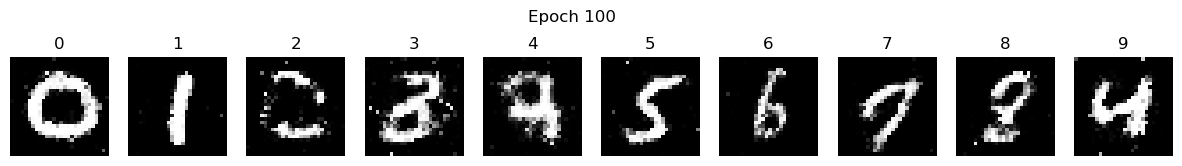

In [20]:
latent_dim = 100
fixed_z = torch.randn(10, latent_dim, device=device)
fixed_labels = torch.arange(0, 10, device=device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

epochs = 100
G_losses = []
D_losses = []
for epoch in range(1, epochs + 1):
    for images, labels in dataloader:
        images = images.view(images.size(0), -1)  # [B, 1, 28, 28] → [B, 784]
        images = images * 2.0 - 1.0  # 归一化到 [-1, 1]
        images, labels = images.to(device), labels.to(device)

        valid = torch.ones(images.size(0), 1, device=device)
        fake = torch.zeros(images.size(0), 1, device=device)

        # ---------------------
        #  Train D
        # ---------------------
        optimizer_D.zero_grad()

        real_pred = discriminator(images, labels)
        d_real_loss = criterion(real_pred, valid)

        z = torch.randn(images.size(0), latent_dim, device=device)
        gen_images = generator(z, labels)
        fake_pred = discriminator(gen_images.detach(), labels)
        d_fake_loss = criterion(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train G
        # ---------------------
        optimizer_G.zero_grad()

        gen_pred = discriminator(gen_images, labels)
        g_loss = criterion(gen_pred, valid)

        g_loss.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch:03d}/{epochs}] | "
        f"G Loss: {g_loss:.4f} | "
        f"D Loss: {d_loss:.4f}"
    )
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # -------- 每 10 个 epoch 可视化 --------
    if epoch % 10 == 0:
        generator.eval()
        with torch.no_grad():
            samples = generator(fixed_z, fixed_labels)
            samples = (samples + 1) / 2.0
            samples = samples.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axes[i].imshow(samples[i], cmap="gray")
            axes[i].set_title(str(i))
            axes[i].axis("off")

        plt.suptitle(f"Epoch {epoch}")
        plt.show()
        generator.train()

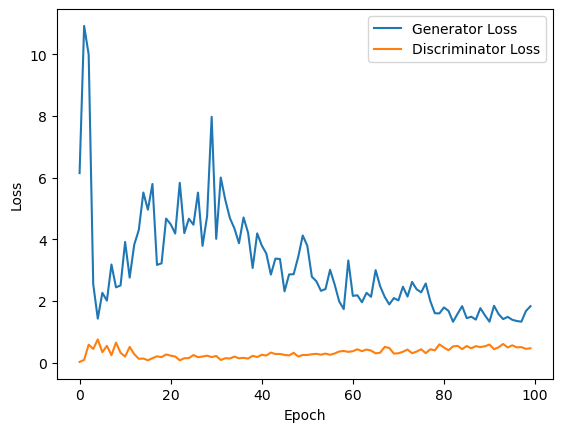

In [21]:
plt.figure()
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## WGAN（Wasserstein GAN）
- 使用 WGAN 损失函数替代原始 GAN 的 BCE 损失
- 判别器由概率输出改为实值输出，去除 Sigmoid
- 网络结构由全连接改为卷积（DCGAN 风格）
- 生成器引入 Conditional Batch Normalization
- 判别器采用 Projection Discriminator 进行条件建模
- 判别器卷积层使用 Spectral Normalization
- 调整 Adam 优化器参数为 betas=(0.0, 0.9)

In [22]:
import torch.nn.utils.spectral_norm as spectral_norm


class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].normal_(1, 0.02)
        self.embed.weight.data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(
            -1, self.num_features, 1, 1
        )
        return out


class Generator(nn.Module):
    def __init__(self, latent_dim, num_class, nc=1, ngf=128, embed_dim=100):
        super().__init__()

        self.label_emb = nn.Embedding(num_class, embed_dim)

        input_dim = latent_dim + embed_dim
        self.tconv1 = nn.ConvTranspose2d(
            input_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False
        )
        self.cbn1 = ConditionalBatchNorm2d(ngf * 8, num_class)
        self.prelu1 = nn.PReLU()
        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(
            ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.cbn2 = ConditionalBatchNorm2d(ngf * 4, num_class)
        self.prelu2 = nn.PReLU()
        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(
            ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.cbn3 = ConditionalBatchNorm2d(ngf * 2, num_class)
        self.prelu3 = nn.PReLU()
        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(
            ngf * 2, nc, kernel_size=4, stride=2, padding=3, bias=False
        )
        # Output Dimension: (nc) x 28 x 28

    def forward(self, x, labels):
        label_embed = self.label_emb(labels)  # [B, embed_dim]
        x = torch.cat([x, label_embed], dim=1)  # [B, latent_dim]
        x = x.unsqueeze(2).unsqueeze(3)  # [B, embed_dim, 1, 1]

        x = self.prelu1(self.cbn1(self.tconv1(x), labels))
        x = self.prelu2(self.cbn2(self.tconv2(x), labels))
        x = self.prelu3(self.cbn3(self.tconv3(x), labels))
        x = torch.tanh(self.tconv4(x))

        return x


class Discriminator(nn.Module):
    def __init__(self, num_class, nc=1, ndf=128):
        super().__init__()
        self.num_class = num_class
        self.ndf = ndf
        self.label_embed = nn.Embedding(self.num_class, ndf * 4)

        self.conv1 = spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1))  # 28*28->14*14
        self.conv2 = spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1))  # 14*14->7*7
        self.conv3 = spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1))  # 7*7->4*4
        self.final = spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0))  # 4*4->1*1

        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()

    def forward(self, x, labels):
        h = self.prelu1(self.conv1(x))
        h = self.prelu2(self.conv2(h))
        h = self.prelu3(self.conv3(h))

        out = self.final(h).view(-1)  # [B]

        # projection term
        h_pool = torch.sum(h, dim=(2, 3))  # [B, ndf*4]
        emb = self.label_embed(labels)  # [B, ndf*4]
        proj = torch.sum(h_pool * emb, dim=1)  # [B]

        return out + proj

Epoch [001/100] | G Loss: 2.0563 | D Loss: -3.4225
Epoch [002/100] | G Loss: -1.0174 | D Loss: -4.0150
Epoch [003/100] | G Loss: 0.2931 | D Loss: -3.7578
Epoch [004/100] | G Loss: 2.4286 | D Loss: -3.2596
Epoch [005/100] | G Loss: 6.6931 | D Loss: -4.0036
Epoch [006/100] | G Loss: 0.5197 | D Loss: -4.2080
Epoch [007/100] | G Loss: -1.8606 | D Loss: -3.1667
Epoch [008/100] | G Loss: 1.4108 | D Loss: -5.3507
Epoch [009/100] | G Loss: -1.0851 | D Loss: -5.0381
Epoch [010/100] | G Loss: 3.9044 | D Loss: -2.1833


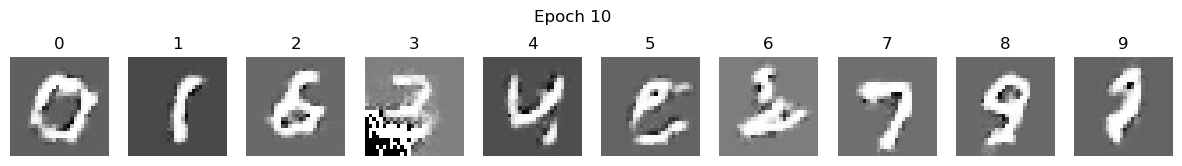

Epoch [011/100] | G Loss: -2.6695 | D Loss: -4.5878
Epoch [012/100] | G Loss: 5.1533 | D Loss: -5.2363
Epoch [013/100] | G Loss: 6.8418 | D Loss: -6.4439
Epoch [014/100] | G Loss: -0.2081 | D Loss: -3.2084
Epoch [015/100] | G Loss: 4.5106 | D Loss: -4.7665
Epoch [016/100] | G Loss: 6.3854 | D Loss: -2.4317
Epoch [017/100] | G Loss: -1.0665 | D Loss: -2.4003
Epoch [018/100] | G Loss: -4.6266 | D Loss: -1.7951
Epoch [019/100] | G Loss: -3.5207 | D Loss: -1.8083
Epoch [020/100] | G Loss: -4.5251 | D Loss: -2.2329


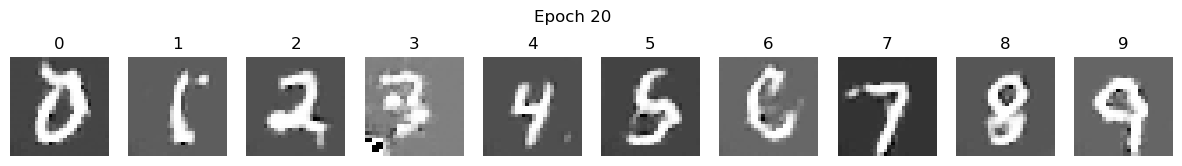

Epoch [021/100] | G Loss: -6.0409 | D Loss: -2.0969
Epoch [022/100] | G Loss: 1.5840 | D Loss: -0.8758
Epoch [023/100] | G Loss: 0.2472 | D Loss: -1.0316
Epoch [024/100] | G Loss: -1.8724 | D Loss: -0.9599
Epoch [025/100] | G Loss: -1.8303 | D Loss: -0.1174
Epoch [026/100] | G Loss: -3.2145 | D Loss: -0.1566
Epoch [027/100] | G Loss: -3.0115 | D Loss: -0.1215
Epoch [028/100] | G Loss: -2.8710 | D Loss: -0.0384
Epoch [029/100] | G Loss: -2.2896 | D Loss: -0.0706
Epoch [030/100] | G Loss: -1.5918 | D Loss: -0.0481


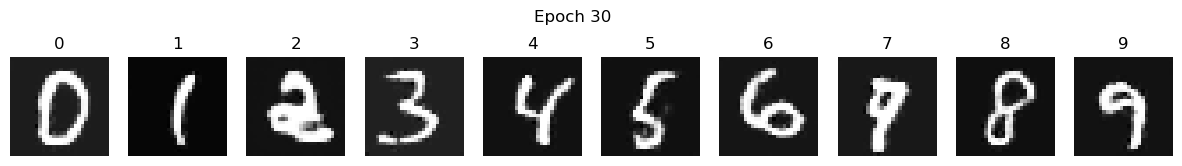

Epoch [031/100] | G Loss: -3.0769 | D Loss: -0.0877
Epoch [032/100] | G Loss: -1.1934 | D Loss: -0.0384
Epoch [033/100] | G Loss: -1.6926 | D Loss: -0.0285
Epoch [034/100] | G Loss: -1.2101 | D Loss: -0.0334
Epoch [035/100] | G Loss: -0.8926 | D Loss: -0.0307
Epoch [036/100] | G Loss: -1.0877 | D Loss: -0.0155
Epoch [037/100] | G Loss: -1.3214 | D Loss: -0.0404
Epoch [038/100] | G Loss: -1.0977 | D Loss: -0.0558
Epoch [039/100] | G Loss: -0.8269 | D Loss: -0.0277
Epoch [040/100] | G Loss: -0.5195 | D Loss: -0.0152


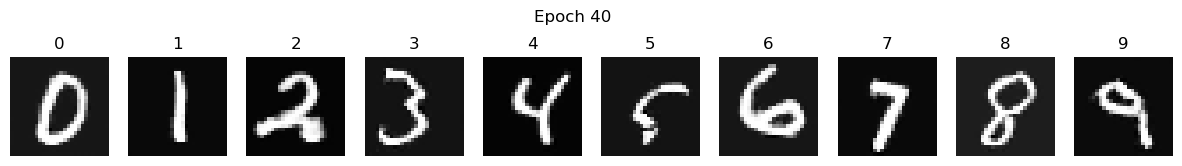

Epoch [041/100] | G Loss: -0.7949 | D Loss: -0.0493
Epoch [042/100] | G Loss: -0.5859 | D Loss: -0.0213
Epoch [043/100] | G Loss: -0.5484 | D Loss: -0.0088
Epoch [044/100] | G Loss: -0.6084 | D Loss: -0.0287
Epoch [045/100] | G Loss: -1.2290 | D Loss: -0.0124
Epoch [046/100] | G Loss: -0.7454 | D Loss: -0.0224
Epoch [047/100] | G Loss: -1.5138 | D Loss: -0.0437
Epoch [048/100] | G Loss: -0.5553 | D Loss: -0.0101
Epoch [049/100] | G Loss: -0.5752 | D Loss: -0.0071
Epoch [050/100] | G Loss: -1.1335 | D Loss: -0.0052


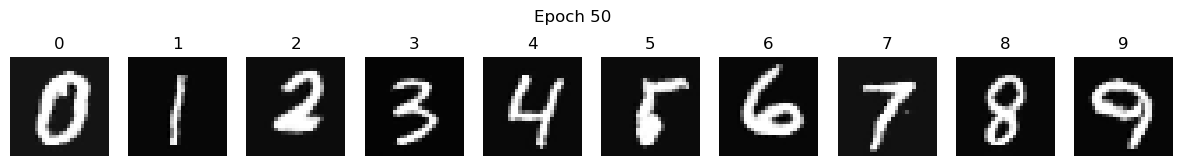

Epoch [051/100] | G Loss: -1.3365 | D Loss: -0.0311
Epoch [052/100] | G Loss: -1.0409 | D Loss: -0.0162
Epoch [053/100] | G Loss: -0.6113 | D Loss: -0.0043
Epoch [054/100] | G Loss: -0.8050 | D Loss: -0.0063
Epoch [055/100] | G Loss: -0.8289 | D Loss: -0.0054
Epoch [056/100] | G Loss: -1.0626 | D Loss: -0.0168
Epoch [057/100] | G Loss: -0.5420 | D Loss: -0.0080
Epoch [058/100] | G Loss: -1.0872 | D Loss: -0.0241
Epoch [059/100] | G Loss: -0.9073 | D Loss: -0.0135
Epoch [060/100] | G Loss: -1.0450 | D Loss: -0.0060


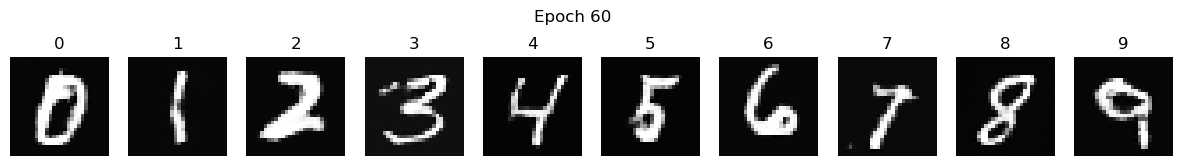

Epoch [061/100] | G Loss: -1.0178 | D Loss: -0.0060
Epoch [062/100] | G Loss: -0.9837 | D Loss: -0.0095
Epoch [063/100] | G Loss: -1.0680 | D Loss: -0.0148
Epoch [064/100] | G Loss: -0.9544 | D Loss: 0.0027
Epoch [065/100] | G Loss: -0.7923 | D Loss: -0.0075
Epoch [066/100] | G Loss: -1.0804 | D Loss: -0.0187
Epoch [067/100] | G Loss: -0.8209 | D Loss: -0.0085
Epoch [068/100] | G Loss: -1.1581 | D Loss: -0.0110
Epoch [069/100] | G Loss: -0.9738 | D Loss: -0.0086
Epoch [070/100] | G Loss: -0.9943 | D Loss: -0.0068


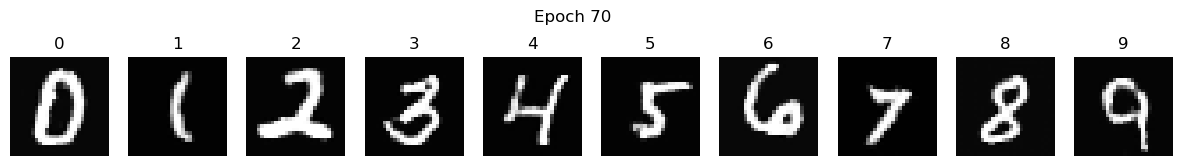

Epoch [071/100] | G Loss: -0.9032 | D Loss: -0.0172
Epoch [072/100] | G Loss: -1.1004 | D Loss: -0.0074
Epoch [073/100] | G Loss: -1.0804 | D Loss: -0.0136
Epoch [074/100] | G Loss: -0.8512 | D Loss: -0.0013
Epoch [075/100] | G Loss: -1.2224 | D Loss: -0.0136
Epoch [076/100] | G Loss: -0.9680 | D Loss: -0.0063
Epoch [077/100] | G Loss: -0.9245 | D Loss: -0.0051
Epoch [078/100] | G Loss: -1.1159 | D Loss: 0.0236
Epoch [079/100] | G Loss: -1.0598 | D Loss: -0.0109
Epoch [080/100] | G Loss: -0.9244 | D Loss: -0.0069


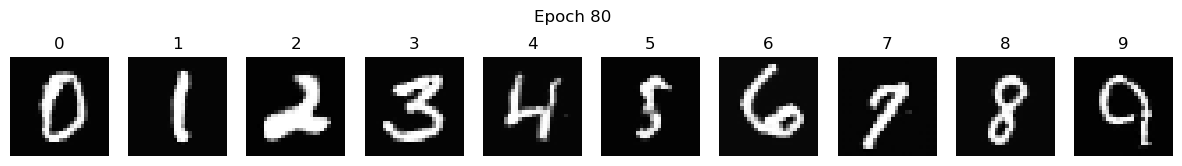

Epoch [081/100] | G Loss: -0.8716 | D Loss: -0.0257
Epoch [082/100] | G Loss: -0.7437 | D Loss: 0.0012
Epoch [083/100] | G Loss: -0.9471 | D Loss: -0.0032
Epoch [084/100] | G Loss: -0.8485 | D Loss: -0.0003
Epoch [085/100] | G Loss: -1.0029 | D Loss: -0.0166
Epoch [086/100] | G Loss: -0.8708 | D Loss: -0.0121
Epoch [087/100] | G Loss: -1.1457 | D Loss: -0.0126
Epoch [088/100] | G Loss: -1.1023 | D Loss: -0.0182
Epoch [089/100] | G Loss: -0.9174 | D Loss: -0.0167
Epoch [090/100] | G Loss: -0.7482 | D Loss: -0.0052


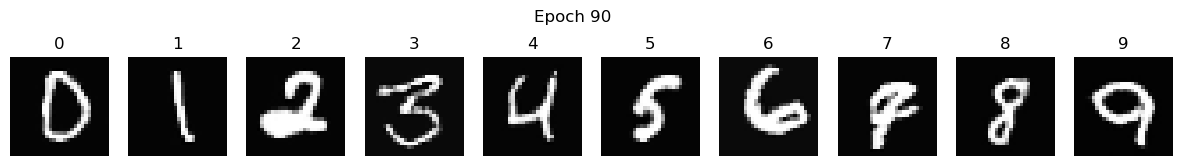

Epoch [091/100] | G Loss: -1.0196 | D Loss: -0.0027
Epoch [092/100] | G Loss: -1.3273 | D Loss: -0.0056
Epoch [093/100] | G Loss: -0.9733 | D Loss: -0.0129
Epoch [094/100] | G Loss: -0.9215 | D Loss: -0.0024
Epoch [095/100] | G Loss: -0.6330 | D Loss: -0.0164
Epoch [096/100] | G Loss: -1.0698 | D Loss: -0.0095
Epoch [097/100] | G Loss: -1.0390 | D Loss: -0.0092
Epoch [098/100] | G Loss: -1.0926 | D Loss: -0.0066
Epoch [099/100] | G Loss: -0.7708 | D Loss: -0.0105
Epoch [100/100] | G Loss: -0.9203 | D Loss: -0.0102


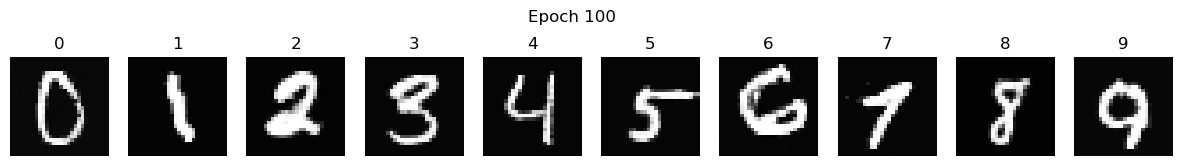

In [23]:
latent_dim = 100
num_class = 10
fixed_z = torch.randn(10, latent_dim, device=device)
fixed_labels = torch.arange(0, 10, device=device)
generator = Generator(latent_dim, num_class).to(device)
discriminator = Discriminator(num_class).to(device)

optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=2e-4, betas=(0.0, 0.9), weight_decay=1e-3
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=2e-4, betas=(0.0, 0.9), weight_decay=1e-3
)

epochs = 100
G_losses = []
D_losses = []
for epoch in range(1, epochs + 1):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # ---------------------
        #  Train D
        # ---------------------
        optimizer_D.zero_grad()

        d_real_loss = discriminator(images, labels)

        z = torch.randn(images.size(0), latent_dim, device=device)
        gen_images = generator(z, labels)
        d_fake_loss = discriminator(gen_images.detach(), labels)
        d_loss = torch.mean(d_fake_loss) - torch.mean(d_real_loss)
        d_loss.backward()
        optimizer_D.step()

        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # ---------------------
        #  Train G
        # ---------------------
        optimizer_G.zero_grad()
        z = torch.randn(images.size(0), latent_dim, device=device)
        gen_images = generator(z, labels)
        g_loss = -torch.mean(discriminator(gen_images, labels))

        g_loss.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch:03d}/{epochs}] | "
        f"G Loss: {g_loss:.4f} | "
        f"D Loss: {d_loss:.4f}"
    )
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # -------- 每 10 个 epoch 可视化 --------
    if epoch % 10 == 0:
        generator.eval()
        with torch.no_grad():
            samples = generator(fixed_z, fixed_labels)
            # samples = (samples + 1) / 2.0
            samples = samples.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axes[i].imshow(samples[i], cmap="gray")
            axes[i].set_title(str(i))
            axes[i].axis("off")

        plt.suptitle(f"Epoch {epoch}")
        plt.show()
        generator.train()

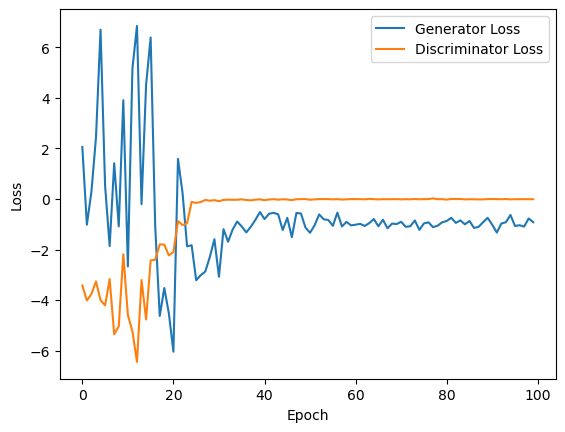

In [24]:
plt.figure()
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()